In [ ]:
!gdown --id 1hTHkxahSpFQ6qAa-dwMz88gBrJ6jxkfh
!gdown --id 1L5D9PmJvQB_ExIiCzVClpSJ8vH1rdj2z

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hTHkxahSpFQ6qAa-dwMz88gBrJ6jxkfh
To: /content/Data_Gasoline.xlsx
100% 12.8M/12.8M [00:00<00:00, 37.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L5D9PmJvQB_ExIiCzVClpSJ8vH1rdj2z
To: /content/Data_Tes2.xlsx
100% 72.5k/72.5k [00:00<00:00, 16.8MB/s]


In [ ]:
!pip install bayesian-optimization

In [ ]:
!pip install scikeras

In [ ]:
!pip install -q -U keras-tuner
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from sklearn.metrics import r2_score
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
data_gasoline = pd.read_excel('Data_Gasoline.xlsx')
# data_gasoline = data_gasoline[:100]

In [ ]:
X = data_gasoline[["CO", "HC", "Usia"]]
y = data_gasoline["Rating"]

X = X.values
y = y.values.reshape(-1,1)

In [ ]:
# Create an instance of the StandardScaler
scaler = MinMaxScaler()

# Fit the scaler to the data
scaler.fit(X)
# Transform the data
x_scaled_gasoline = scaler.transform(X)

# Fit the scaler to the data
scaler.fit(y)
# Transform the data
y_scaled_gasoline = scaler.transform(y)

In [ ]:
# X_optimize, X_train, y_optimize, y_train = train_test_split(x_scaled_gasoline, y_scaled_gasoline, test_size=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x_scaled_gasoline, y_scaled_gasoline, test_size=0.02, random_state=42)

In [ ]:
# Define the scoring function (example using R^2 score)
score_acc = make_scorer(r2_score)

In [ ]:
params_nn2 ={
    'neurons': (1, 10),
    'activation':(0, 7),
    'optimizer':(0,7),
    'learning_rate':(0.01, 0.1),
    'batch_size':(20, 30),
    'epochs':(20, 100),
    'num_layers' : (2,8),
    # 'normalization':(0,0.75),
    'dropout':(0,1),
    # 'dropout_rate':(0,0.1)
}

In [ ]:
# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,num_layers, dropout):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD = {'Adam': Adam(learning_rate=learning_rate), 'SGD': SGD(learning_rate=learning_rate),
                  'RMSprop': RMSprop(learning_rate=learning_rate), 'Adadelta': Adadelta(learning_rate=learning_rate),
                  'Adagrad': Adagrad(learning_rate=learning_rate), 'Adamax': Adamax(learning_rate=learning_rate),
                  'Nadam': Nadam(learning_rate=learning_rate), 'Ftrl': Ftrl(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    num_layers = round(num_layers)

    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))

        for i in range(num_layers):
          if i == 0:
              nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
              nn.add(Dropout(0.1, seed=123))
          else:
              nn.add(Dense(neurons, activation=activation))
              nn.add(Dropout(0.1, seed=123))

        nn.add(Dense(1, activation= 'sigmoid'))
        nn.compile(loss='mean_squared_error', optimizer=optimizer)
        return nn

    es = EarlyStopping(monitor='loss', patience=20, verbose=0)
    nn = KerasRegressor(model=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)

    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    return r2
    # kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    # scores = cross_val_score(nn, X_optimize, y_optimize, scoring=score_acc, cv=kfold, fit_params={'callbacks': [es]}) #data optimasi
    # return scores.mean()

In [ ]:
# Run Bayesian Optimization
tuner = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)

In [ ]:
tuner.maximize(init_points=5, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  |  epochs   | learni... |  neurons  | num_la... | optimizer |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8818    | 4.285     | 21.69     | 0.4361    | 81.54     | 0.03658   | 2.342     | 2.135     | 2.942     |
| 2         | 0.8875    | 1.671     | 23.38     | 0.9907    | 39.02     | 0.01731   | 7.026     | 5.727     | 1.92      |
| 3         | -2.585e-0 | 3.264     | 21.18     | 0.07396   | 92.06     | 0.08146   | 8.565     | 6.891     | 6.937     |
| 4         | 0.7477    | 4.041     | 28.14     | 0.4213    | 22.2      | 0.05087   | 1.948     | 6.903     | 4.884     |
| 5         | 0.794     | 3.957     | 22.74     | 0.9985    | 31.04     | 0.06539   | 5.365     | 4.43      | 5.095     |
| 6         | 0.8696    | 1.162     | 27.47     | 0.5587    | 34.43     | 0.01      | 4.895     | 7.815     | 1.06      |
| 7         | 0.8215    

In [ ]:
# Get the best parameters
best_params = tuner.max['params']
print("Best Parameters:", best_params)

Best Parameters: {'activation': 1.6707749887251224, 'batch_size': 23.376561918887923, 'dropout': 0.9907124646308787, 'epochs': 39.01811631200182, 'learning_rate': 0.017307339350609043, 'neurons': 7.026402144219668, 'num_layers': 5.727457516404182, 'optimizer': 1.919774711445629}


In [ ]:
params_nn_ = tuner.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['num_layers'] = round(params_nn_['num_layers'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'softplus',
 'batch_size': 23,
 'dropout': 0.9907124646308787,
 'epochs': 39,
 'learning_rate': 0.017307339350609043,
 'neurons': 7,
 'num_layers': 6,
 'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop at 0x79fd11b47820>}

In [ ]:
# Fitting Neural Network
def nn_cl_fun():
  nn = Sequential()
  nn.add(Dense(params_nn_['neurons'], input_dim=X_train.shape[1], activation=params_nn_['activation']))
  for i in range(params_nn_['num_layers'] ):
      if i == 0:
        nn.add(Dense(params_nn_['neurons'], input_dim=X_train.shape[1], activation=params_nn_['activation']))
        if params_nn_['dropout'] > 0.5:
          nn.add(Dropout(0.1, seed=123))
        else:
          nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
          nn.add(Dropout(0.1, seed=123))

  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(loss='mean_squared_error', optimizer=params_nn_['optimizer'], metrics=tfa.metrics.r_square.RSquare())
  return nn

In [ ]:
es = EarlyStopping(monitor='loss', verbose=0, patience=20)
model =nn_cl_fun ()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 7)                 28        
                                                                 
 dense_69 (Dense)            (None, 7)                 56        
                                                                 
 dropout_50 (Dropout)        (None, 7)                 0         
                                                                 
 dense_70 (Dense)            (None, 1)                 8         
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs= params_nn_['epochs'], callbacks = [es], validation_split=0.2, batch_size=params_nn_['batch_size'])

Epoch 1/39
9310/9310 [==============================] - 25s 2ms/step - loss: 0.0053 - r_square: 0.8625 - val_loss: 0.0035 - val_r_square: 0.9089
Epoch 2/39
9310/9310 [==============================] - 21s 2ms/step - loss: 0.0043 - r_square: 0.8878 - val_loss: 0.0033 - val_r_square: 0.9153
Epoch 3/39
9310/9310 [==============================] - 23s 3ms/step - loss: 0.0042 - r_square: 0.8914 - val_loss: 0.0032 - val_r_square: 0.9165
Epoch 4/39
9310/9310 [==============================] - 23s 2ms/step - loss: 0.0041 - r_square: 0.8933 - val_loss: 0.0030 - val_r_square: 0.9228
Epoch 5/39
9310/9310 [==============================] - 23s 2ms/step - loss: 0.0041 - r_square: 0.8948 - val_loss: 0.0034 - val_r_square: 0.9107
Epoch 6/39
9310/9310 [==============================] - 22s 2ms/step - loss: 0.0040 - r_square: 0.8956 - val_loss: 0.0029 - val_r_square: 0.9239
Epoch 7/39
9310/9310 [==============================] - 22s 2ms/step - loss: 0.0040 - r_square: 0.8959 - val_loss: 0.0029 - val_r_

In [ ]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

171/171 [==============================] - 0s 1ms/step - loss: 0.0029 - r_square: 0.9233
[test loss, test accuracy]: [0.0028773294761776924, 0.9233445525169373]


In [ ]:
model.save('model_gasoline.h5')

FUNGSI UNTUK MEMVISUALISASI PERUBAHAN LOSS DAN R2 SCORE

In [ ]:
def make_plot(train, validation, title):
  graph = plt.plot(history.history[train])
  graph = plt.plot(history.history[validation])
  graph = plt.title(title)
  graph = plt.legend(['training', 'validation'])
  graph = plt.show()
  return graph

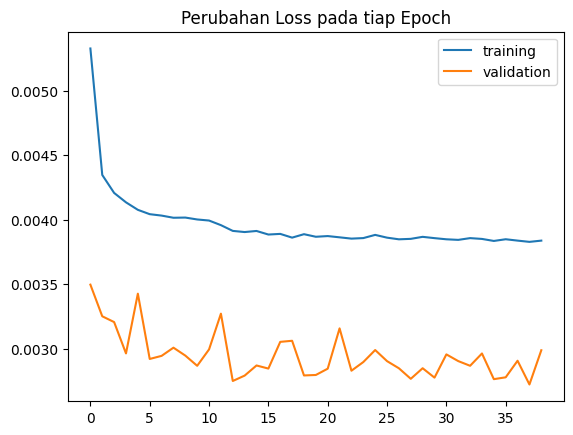

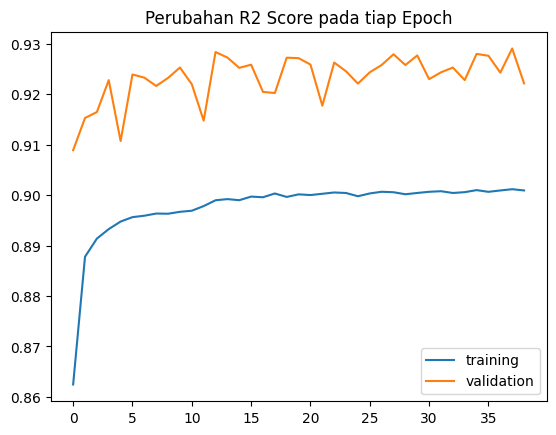

In [ ]:
make_plot('loss', 'val_loss', 'Perubahan Loss pada tiap Epoch')
make_plot('r_square', 'val_r_square', 'Perubahan R2 Score pada tiap Epoch')